# Ejemplo02
## Dr. Antonio Arista Jalife

En este ejemplo implementaremos el algoritmo de retropropagación por completo. Para ello, vamos a tomar el ejemplo de la sesión pasada: Crearemos 2 blobs con 10 características en cada dato.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

Vamos a construir un dataset, sin embargo necesitamos que tenga cierta forma: Los datos de entrada deben tener la forma (num de caracteristicas, num de muestras). Y los datos de salida deben tener la forma (num de datos de salida, num de muestras). Para ello requieres modificar la forma y hacer transposiciones

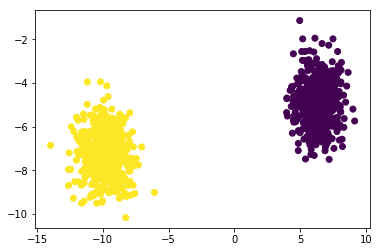

Datos de entrenamiento en X:(Numero de caracteristicas, Numero de muestras)
(10, 600)
Y_train shape:(Numero de datos de salida (1), Numero de muestras)
(1, 600)


In [2]:
x, y = make_blobs(n_samples=1000, centers=2, n_features=10)
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4)

x_train = x_train.T
x_test = x_test.T
y_train = y_train.reshape(y_train.shape[0],1).T
y_test = y_test.reshape(y_test.shape[0],1).T

print("Datos de entrenamiento en X:(Numero de caracteristicas, Numero de muestras)")
print(x_train.shape)
print("Y_train shape:(Numero de datos de salida (1), Numero de muestras)")
print(y_train.shape)

## FrontPropagation
Funciones de la sesión pasada y el ejemplo pasado

In [3]:
def inicializarCapa(numCaracteristicas, numNeuronas):
    w = np.random.rand(numNeuronas,numCaracteristicas)    
    b = np.random.rand(numNeuronas,1)
    return w,b

def calcularZ(w,x,b):
    z = np.dot(w,x) + b     
    return z

def activacion(z):
    y = 1 / (1 + np.exp(-z))
    return y

def capaNeuronal(w,x,b):
    z = calcularZ(w,x,b)
    y_pred = activacion(z)
    return z, y_pred

## Cálculo del error
En este caso utilizaremos nuevamente el cálculo del error. Es importante que dividamos el error por el número de muestras para que el error sea un promedio y no un número enorme.

In [4]:
def calcularError(y_esperado, y_obtenido):
    numMuestras = y_esperado.shape[0]
    error = - (y_esperado *np.log(y_obtenido) + (1 - y_esperado)*np.log(1 - y_obtenido))
    error = np.sum(error) / numMuestras
    return error

## Backpropagation.
Para calcular la retropropagación, se debe calcular las derivadas de la capa final y las derivadas de las capas intermedias. las derivadas de la capa final se calculan de la siguiente manera (igual que el ejemplo anterior):

In [5]:
def calcular_derivadas_capaFinal(y_esperado, y_obtenido, entradaCapaActual,numMuestras):
    dz = y_obtenido - y_esperado    
    dw = (1 / numMuestras) * np.dot(dz,entradaCapaActual.T)
    db = (1 / numMuestras) * np.sum(dz, axis=1, keepdims=True)
    return dz, dw, db

Mientras que las capas intermedias se calculan con la siguiente fórmula.

$\frac{dE}{dz}^{l} = W^{T} \cdot \frac{dE}{dz}^{l-1} \times (1 - Z^{2})$

$\frac{dE}{dw} = \frac{1}{m} \cdot \frac{dE}{dz} X^{l-1}$

$\frac{dE}{db} = \frac{1}{m} \cdot \frac{dE}{dz}$

In [6]:
def calcular_derivadas_capasIntermedias(dz_capaSiguiente, w_capaSiguiente, salidaCapaActual, entradaCapaActual, numMuestras):
    dz = np.multiply(np.dot(w_capaSiguiente.T, dz_capaSiguiente), 1 - np.power(salidaCapaActual, 2))
    dw = (1 / numMuestras) * np.dot(dz,entradaCapaActual.T)
    db = (1 / numMuestras) * np.sum(dz, axis=1, keepdims=True)
    return dz, dw, db

## Entrenamiento.
Ahora, el algoritmo de entrenamiento primero calcula las capas hacia adelante, y luego las capas hacia atrás en retropropagación. La última capa debe ser retropropagada con una función (capaFinal), y las demás con la otra función (capasIntermedias)

In [7]:
#Capa 1
w1,b1 = inicializarCapa(numCaracteristicas = 10,numNeuronas = 4)
#Capa 2
w2,b2 = inicializarCapa(numCaracteristicas = 4,numNeuronas = 2)

lr = 0.01
minError = 4.0
maxEpochs = 100000
m = x_train.shape[1]
for counter in range(0,maxEpochs):
    #Calculamos la capa 1
    z1, a1 = capaNeuronal(w1,x_train,b1)
    #Calculamos la capa 2 con las salidas de la 1
    z2, y_obtenido = capaNeuronal(w2,a1,b2)
    #Calculamos el error.
    error = calcularError(y_train, y_obtenido)
    #Luego calculamos las derivadas de la capa final
    dz2, dw2, db2 = calcular_derivadas_capaFinal(y_esperado= y_train, 
                                                 y_obtenido = y_obtenido,
                                                 entradaCapaActual=a1,
                                                 numMuestras = m)
    
    #Y con la derivada de la capa 2, calculamos la derivada de la capa 1. 
    #Si hubiera mas capas, hay que hacer esto varias veces.
    dz1, dw1, db1 =calcular_derivadas_capasIntermedias(dz_capaSiguiente=dz2,
                                                       w_capaSiguiente=w2,
                                                       salidaCapaActual=a1,
                                                       entradaCapaActual=x_train, 
                                                       numMuestras = m)
    
    #Se ajustan los pesos sinápticos con las derivadas.
    w1 = w1 - lr * dw1
    b1 = b1 - lr * db1
    w2 = w2 - lr * dw2
    b2 = b2 - lr * db2
    
    if(error < minError):
        break;
    
    if counter % 1000 == 0:
        print("Epoch:"+str(counter))
        print("Error: "+str(error))

Epoch:0
Error: 1650.3064565961304


/home/nightcrow/gintelligence/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Epoch:1000
Error: 184.24099596609523
Epoch:2000
Error: 103.20707350518846
Epoch:3000
Error: 72.13906459168805
Epoch:4000
Error: 56.48156742363206
Epoch:5000
Error: 45.34371054450018
Epoch:6000
Error: 39.8877262683776
Epoch:7000
Error: 36.29758122896061
Epoch:8000
Error: 30.125778197735748
Epoch:9000
Error: 25.673676815981192
Epoch:10000
Error: 23.435453569425004
Epoch:11000
Error: 21.56765425600446
Epoch:12000
Error: 18.56562027289496
Epoch:13000
Error: 16.996980740393916
Epoch:14000
Error: 15.862729657123205
Epoch:15000
Error: 14.917996913601904
Epoch:16000
Error: 14.12454199076112
Epoch:17000
Error: 13.436956226634173
Epoch:18000
Error: 12.74151375815064
Epoch:19000
Error: 12.178449008732592
Epoch:20000
Error: 11.766323308297821
Epoch:21000
Error: 11.415035041910802
Epoch:22000
Error: 11.09998083241578
Epoch:23000
Error: 10.813899066564076
Epoch:24000
Error: 10.552878499991532
Epoch:25000
Error: 10.314031144034047
Epoch:26000
Error: 10.095074902918864
Epoch:27000
Error: 9.89408341856

## Probando con datasets de prueba.
Con el dataset de prueba generamos las salidas.

In [8]:
#Probando:
z1, a1 = capaNeuronal(w1,x_train,b1)
#Calculamos la capa 2 con las salidas de la 1
z2, y_obtenido_test = capaNeuronal(w2,a1,b2)

print("Entradas "+str(x_test))
print("Genera salidas "+str(y_obtenido_test))

Entradas [[  5.31688542 -12.24265594 -10.22327781 ...   7.50005583  -9.8109535
    6.90086492]
 [ -4.64920833  -9.27609649  -5.23818007 ...  -5.6385815   -5.95692453
   -4.89023813]
 [ -3.21253382  -1.45021317   0.7733527  ...  -3.44004448   1.21744711
   -1.86642796]
 ...
 [  7.63085856   2.57681465   2.13335181 ...   7.52258639   1.04467335
    5.66120665]
 [ -1.71308428  -5.63505245  -6.37941516 ...  -2.75565161  -6.04981498
    0.17898373]
 [ -7.29767719  -6.48391689  -7.29127394 ... -10.84475047  -4.84089719
   -6.23087581]]
Genera salidas [[0.99857865 0.00283682 0.00283682 ... 0.00283682 0.00283682 0.99857865]
 [0.99851709 0.00268338 0.00268338 ... 0.00268338 0.00268338 0.99851709]]


/home/nightcrow/gintelligence/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
